# Прогнозирование оттока сети фитнес-центра

## Описание проекта

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что клиент больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо.

Индикаторы оттока зависят от специфики отрасли. Когда пользователь редко, но стабильно закупается в интернет-магазине — не похоже, что он «отвалился». А вот если две недели не заходит на канал с ежедневно обновляемым контентом, дела плохи: подписчик заскучал и, кажется, оставил вас.

Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Конечно, не исключено, что он уехал на Бали и по приезде обязательно продолжит ходить на фитнес. Однако чаще бывает наоборот. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся.

Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет.

**Задача: провести анализ и подготовить план действий по удержанию клиентов**

* научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
* сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
* проанализировать основные признаки, наиболее сильно влияющие на отток;
* сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:<br />
     1) выделить целевые группы клиентов;<br />
     2) предложить меры по снижению оттока;<br />
     3) определить другие особенности взаимодействия с клиентами.

**План работ:**
1. <a href='#r1'>Загрузить данные</a>
2. <a href='#r2'>Провести исследовательский анализ данных (EDA)</a>
3. <a href='#r3'>Построить модель прогнозирования оттока клиентов</a>
4. <a href='#r4'>Сделать кластеризацию клиентов</a>
5. <a href='#r5'>Сформулировать выводы и базовые рекомендации по работе с клиентами</a>

## <span id='r1'>Загрузка данных</span>

In [165]:
# Подгружаем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from itertools import combinations
import catboost as cb

In [166]:
# Загружаем датасет и сразу проверим количество строк

path = 'https://code.s3.yandex.net/datasets/'
data = pd.read_csv(path + 'gym_churn.csv')
data.shape

(4000, 14)

Датасет содержить 4000 строк и 14 колонок. Судя по всему, признаков будет немало.

## <span id='r2'>EDA</span>

### Обзор датасета и пропуски

In [167]:
# Подробная информация о колонках
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:

Данные клиента за предыдущий до проверки факта оттока месяц:
* `gender` — пол;
* `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
* `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
* `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
* `Phone` — наличие контактного телефона;
* `Age` — возраст;
* `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
* `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
* `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
* `Group_visits` — факт посещения групповых занятий;
* `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
* `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
* `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.

`Churn` — факт оттока в текущем месяце.


Пропусков не видно. Строковых данных совсем нет, а категорийные столбцы, вроде пола и наличие телефона переведены сразу в числовой вид.

In [168]:
# Для удобства переведём названия колонок в нижний регистр
data.columns = data.columns.str.lower()
data.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

In [169]:
# Посмотрим на состав даных
data.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Как писал выше - здесь видно, что в первых колонках категорийные данные переведены в числа.

In [170]:
# Посмотрим на уникальность бинарных значений. Вдруг, где-то не два значения

col = ['gender', 'near_location', 'partner', 'promo_friends', 
       'phone', 'contract_period', 'group_visits', 'churn']

for c in col:
    print(data[c].value_counts())

1    2041
0    1959
Name: gender, dtype: int64
1    3381
0     619
Name: near_location, dtype: int64
0    2053
1    1947
Name: partner, dtype: int64
0    2766
1    1234
Name: promo_friends, dtype: int64
1    3614
0     386
Name: phone, dtype: int64
1     2207
12     960
6      833
Name: contract_period, dtype: int64
0    2351
1    1649
Name: group_visits, dtype: int64
0    2939
1    1061
Name: churn, dtype: int64


Выбивающихся значений нигде нет. Сразу видно, что группа оттока-оставшихся 1 к 3.

У колонки с месяцами почему-то вещественное значение. Переведём в `int` и посмотрим на текстовое распределение:

In [171]:
# Переведем тип данных в целочисленный

data['month_to_end_contract'] = data['month_to_end_contract'].astype('int64')
data['month_to_end_contract'].value_counts()

1     2207
6      645
12     524
11     181
5      130
10      82
9       73
4       58
8       38
7       25
3       23
2       14
Name: month_to_end_contract, dtype: int64

In [172]:
# Проверим датасет на дубликаты

data.duplicated().sum()

0

Дубликатов строк не найдено.

In [173]:
# Посмотрим на описательную статистику
data.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Крактие выводы по статистике:

* Большинство людей живут рядом с фитнес-центром - **0,84** среднее с небольшим разбросом
* Средний возраст клиентов **29** лет, причём с небольшим стандартным отклонением (**3,25**). В возрасте не видно выбросов в минимальном и максимальном значениях (между **18** и **41**).
* Медиана суммарной выручка от других услуг фитнес-центра: **136** у.е. с отклонением **96** у.е.
* Средняя частота посещений в неделю за все время с начала действия абонемента (медиана): **1,83** при отклонении **0,97**. В неделю за предыдущий месяц так же: **1,71**, при отклонении **1,05**
* Почти половина клиентов пришли по партнерской программе (**48%**)
* Отток клиентов составляет **26%**. Не знаком с общей статистикой фитнес-индустрии, но в наших интересах этот показатель сокращать.
* **30%** клиентов пришли по промокоду от друга
* **90%** клиентов указали телефон
* Средний срок жизни клиента **3,8 месяцев**. При этом большой разброс в **3 месяца**.
* Распределение по полу равномерное, с небольшим превалированием мужского пола (**+1%**)

### Средние значения признаков в группах

In [174]:
# Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался
data_mean = round(data.groupby('churn').mean(), 2).T
data_mean

churn,0,1
gender,0.51,0.51
near_location,0.87,0.77
partner,0.53,0.36
promo_friends,0.35,0.18
phone,0.90,0.90
contract_period,5.75,1.73
group_visits,0.46,0.27
age,29.98,26.99
avg_additional_charges_total,158.45,115.08
month_to_end_contract,5.28,1.66


Для наглядности переведём цифры в графике:

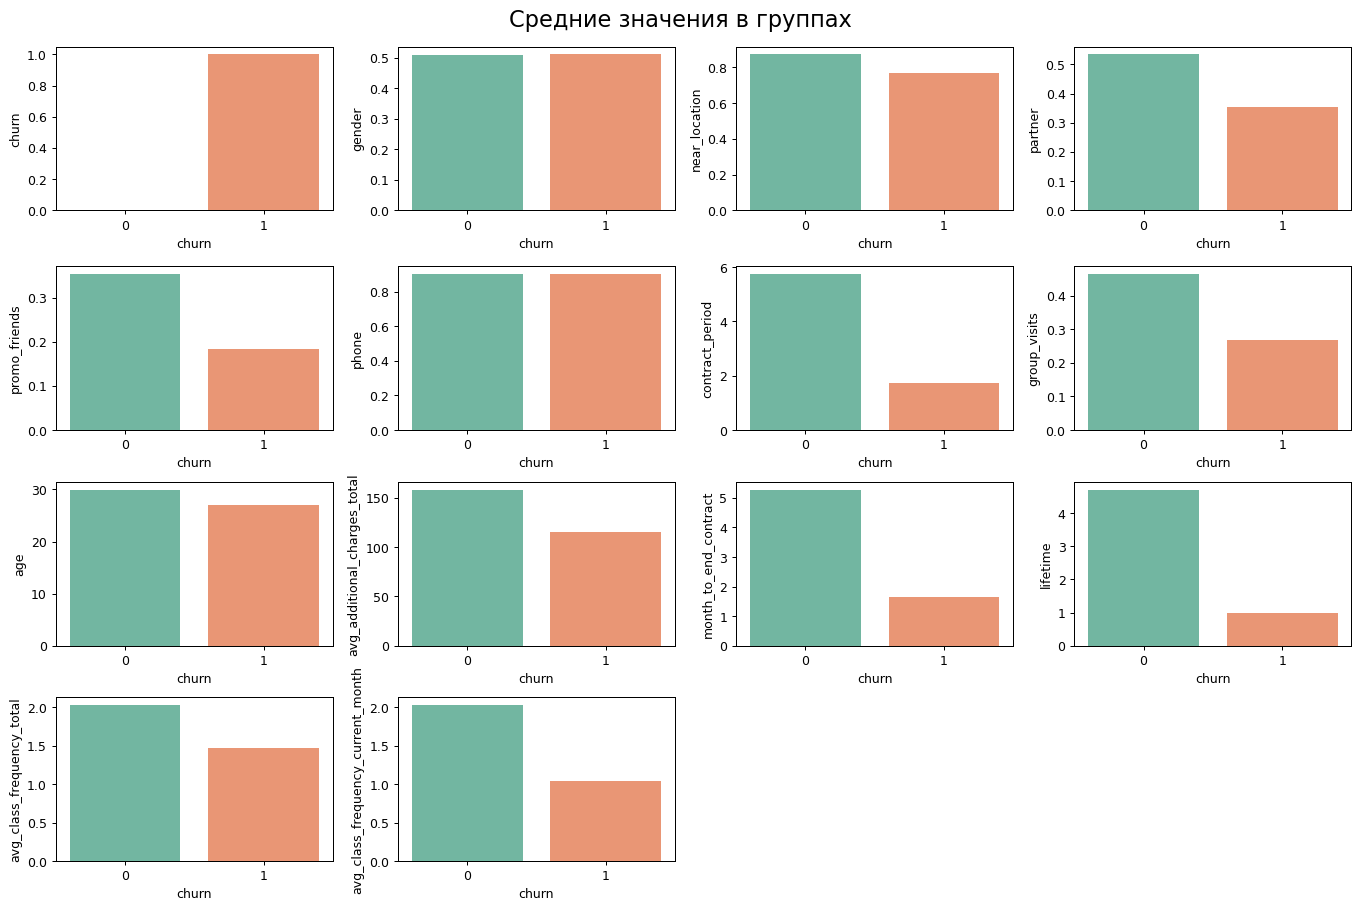

In [175]:
data_mean = data.groupby('churn').mean().reset_index()

# Располагаем графики на одном листе с колонками и рядами
f, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 10), dpi=90, constrained_layout=True)

# В цикле генерим графики по каждому полю
i = 0
for mean in data_mean:
    # Строим графики
    sns.barplot(data=data_mean, x='churn', y=mean, ax=axes[i // 4, i % 4])
    i += 1

# Скрываем пустые графики
axes[3, 2].set_axis_off()
axes[3, 3].set_axis_off()

f.suptitle('Средние значения в группах', fontsize=18);

Из заметного по средним значениям:
* У не-партнёров больше отток, чем у партнёров
* Средняя длительность текущего действующего абонемента у ушедших ближе к месяцу (**0,99** против **4,71**)
* Ушедшие скорее больше не ходят на групповые занятия, чем ходят (**0,27** против **0,47**)
* Средний возраст ушедших ближе к **27** годам, а у оставшихся ближе к **30**
* Ушедшие тратили меньше на доп. услуги, чем оставшиеся (**115** у.е. против **158** у.е.)
* Среднее время с момента первого обращения в фитнес-центр у ушедших - всего **1 месяц**, а у оставшихся **4,7**.
* Ушедшие ходили в неделю реже, чем оставшиеся за всё время наблюдений: **1,47** против **2,02**.
    * А если смотреть только на предыдущий месяц, то разрыв ещё больше: почти **1 раз** против **2-х**.

Нарративом можно сказать, что средний ушедший - это клиент в возрасте 27 лет, который пришёл не по партнёрской программе и не по промокоду друга, со средним сроком жизни абонемента в 1 месяц. При этом абонемент закончится через месяц. Практически не ходил на групповые занятия, тратил меньше на доп. услуги и в 1,5-2 раза меньше посещений в неделю. 

### Столбчатые гистограммы и распределения признаков в группах

*Постройте столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)*

In [176]:
# Функция рисует гистограмму и принимает маркер оттока
def hist_churn(churn, title):
    data_churn = data.query('churn == ' + str(churn))

    # Располагаем графики на одном листе с колонками и рядами
    f, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6), dpi=90, constrained_layout=True)

    # В цикле генерим графики по каждому полю
    i = 0
    j = 0

    for col in ['age', 'avg_additional_charges_total', 'month_to_end_contract', 
              'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']:
        if i == 3:
            i = 0
            j = 1
            
        # Строим графики
        sns.histplot(data_churn[col], ax=axes[j, i], kde=True)
        i += 1
        
    f.suptitle(title, fontsize=16);

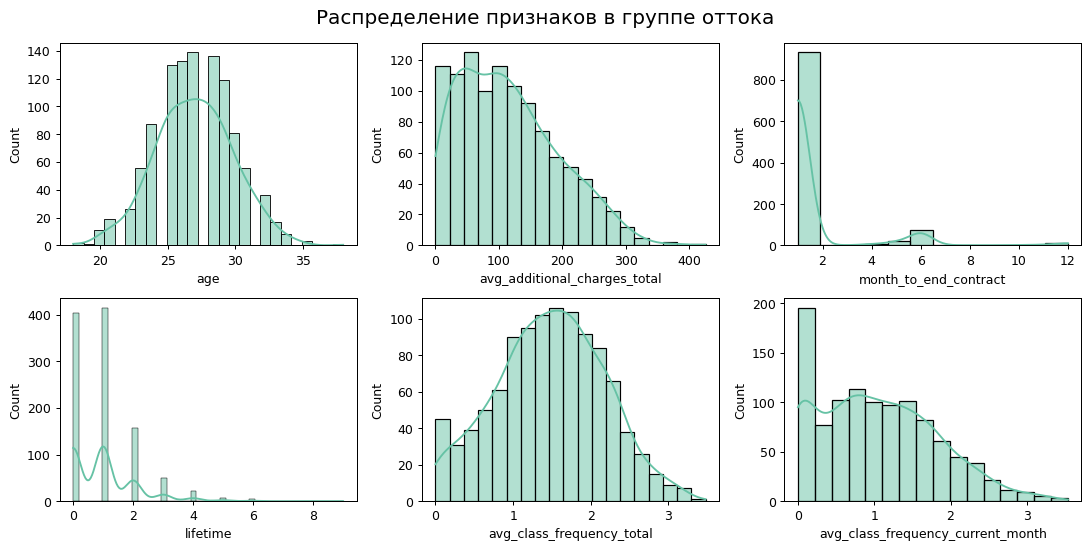

In [177]:
hist_churn(1, 'Распределение признаков в группе оттока')

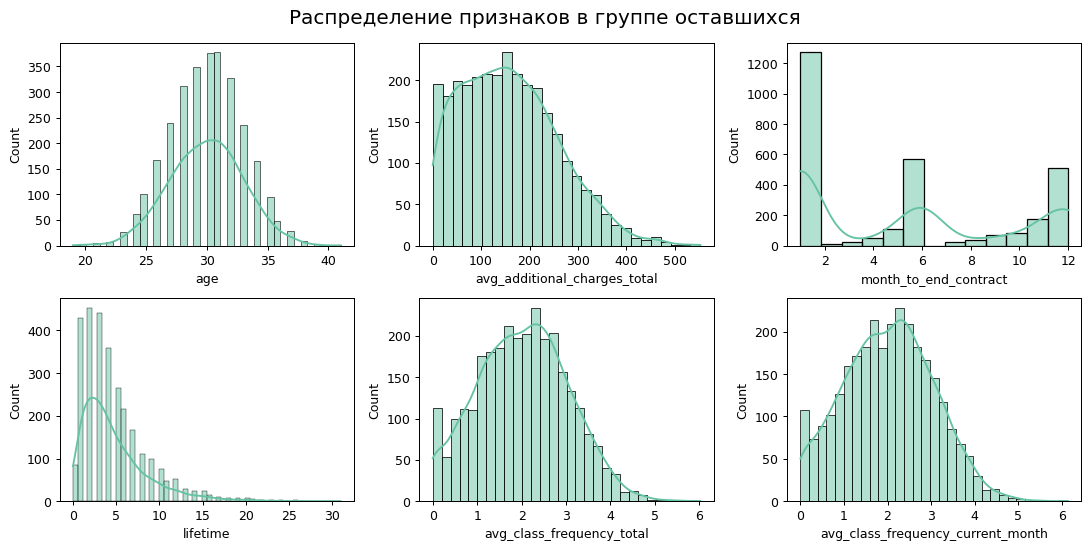

In [178]:
hist_churn(0, 'Распределение признаков в группе оставшихся')

Выводы по **гистограммам**:

* Распределение возраста нормальное. Видно, что среднее у групп отличается. Как писал ранее - у ушедших более молодой возраст.
* Доп. услуги у ушедших намного ниже. Это видно по модам.
* У оставшихся более распределенный график со сроком окончания абонемента: есть пики на 6 и 12 месяцев.
* Лайфтайм у оставшихся более насыщенный и с широким диапозоном

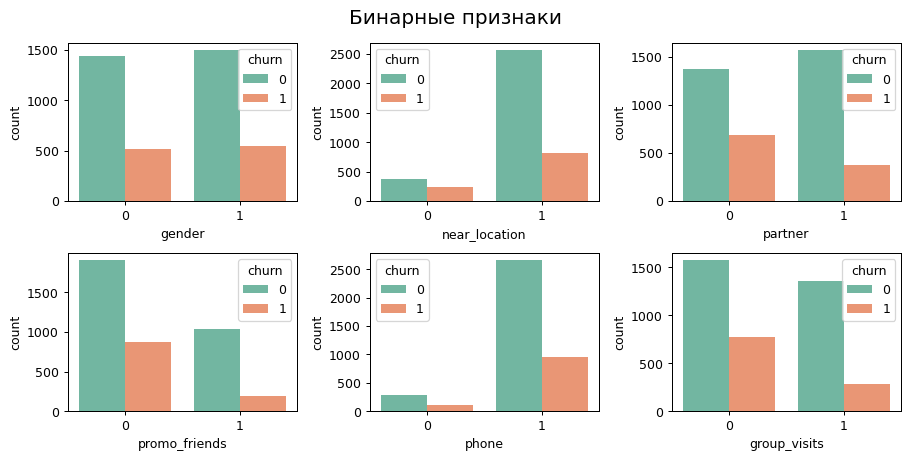

In [179]:
# Располагаем графики на одном листе с колонками и рядами
f, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 5), dpi=90, constrained_layout=True)

# В цикле генерим графики по каждому полю
i = 0
j = 0

for col in ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']:
    if i == 3:
        i = 0
        j = 1
    
    # Строим графики
    sns.set_palette('Set2')
    sns.countplot(data=data, x=data[col], hue='churn', ax=axes[j, i])
    i += 1
        
    f.suptitle('Бинарные признаки', fontsize=16);

Выводы по графикам **бинарных признаков**:
* В группе оттока мужчин больше
* На графике наглядно видно, что большинство клиентов, кто находится в районе фитнес-центра. Закономерно, что там обе группы больше.
* У партнёров меньше оттока
* Если клиент не был приглашён другом, то оттока больше
* Большинство клиентов не пользуются групповыми занятиями, но тех кто пользуется - ушедших достаточно мало.

Построим ящики с усами, чтобы посмотреть на выбросы:

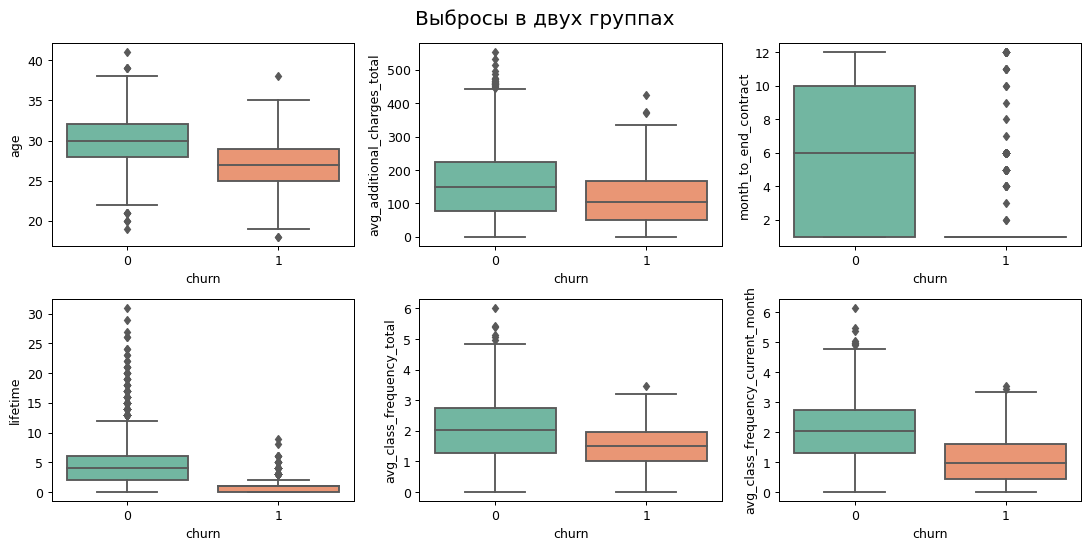

In [180]:
# Ящики с усами
# Располагаем графики на одном листе с колонками и рядами
f, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6), dpi=90, constrained_layout=True)

# В цикле генерим графики по каждому полю
i = 0
j = 0

for col in ['age', 'avg_additional_charges_total', 'month_to_end_contract', 
            'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']:
    if i == 3:
        i = 0
        j = 1
            
    # Строим графики
    sns.boxplot(data=data, x='churn', y=col, ax=axes[j, i])
    i += 1
        
f.suptitle('Выбросы в двух группах', fontsize=16);

Из графиков ящика с усами видно, что верхняя граница срока жизни клиента - 12 месяцев и это может быть связано с годовым абонементом.

Есть очень упорные клиенты, которые ходят по 5 и 6 раз в неделю. 

Интересно, что нет клиентов старше 41 года.


### Матрица корреляций

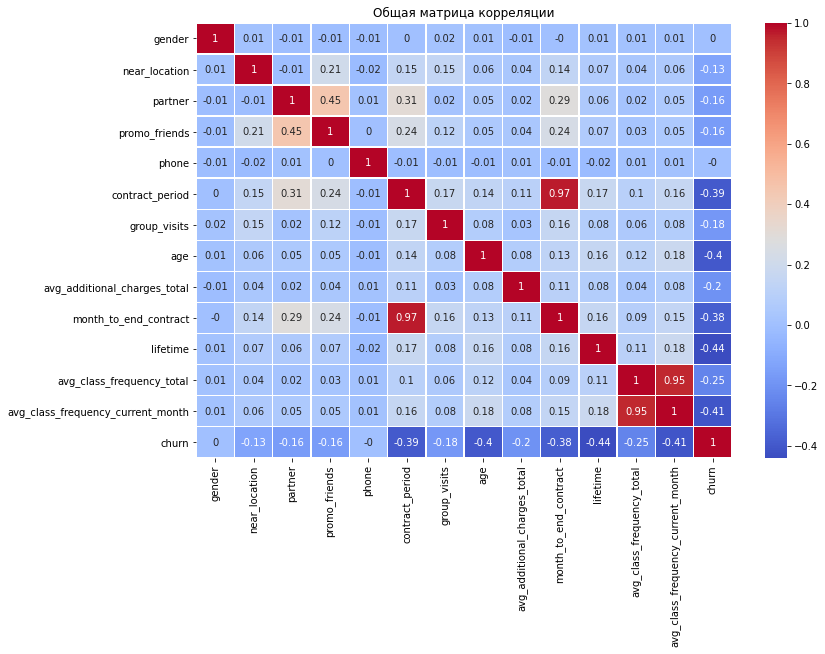

In [181]:
# Строим общую матрицу корреляций
corr = round(data.corr(), 2)

plt.figure(figsize=(12, 8));
sns.heatmap(corr, linewidths=.5, annot = True, cmap='coolwarm').set_title('Общая матрица корреляции');

**Выводы по общей матрице**:
* Есть мультиколлинеарные признаки (**0,97**) между длительностью текущего действующего абонемента и сроком до окончания текущего действующего абонемента. А также между частотами посещения клуба (**0,95**)
* Из интересного - обратная корреляция (**-0,44**) между оттоком и лайфтамом, частотой посещения в текущий месяц (**-0,41**), возрастом (**-0,4**).
* Есть нулевые корреляции между телефоном и промокодом полом и окончанием контракта.

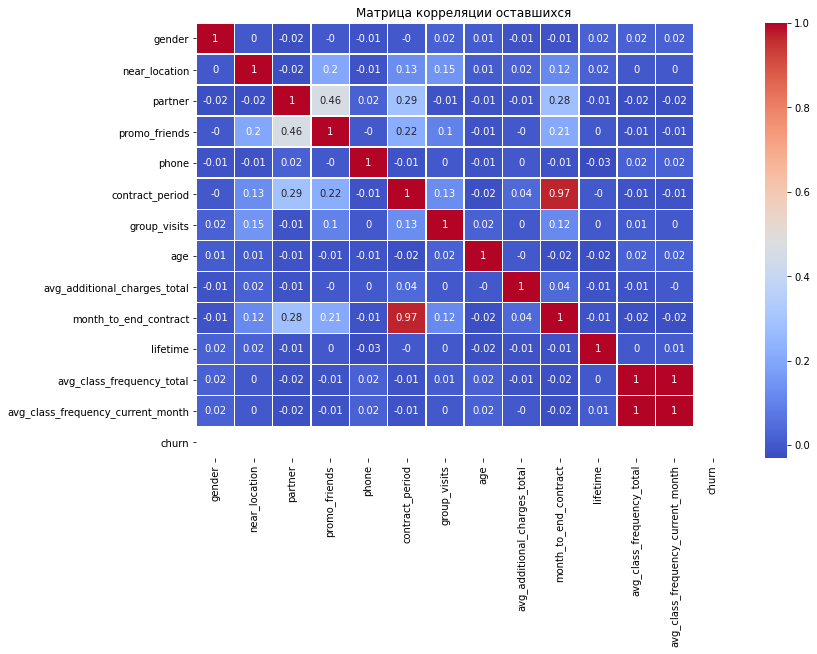

In [182]:
# Строим матрицу корреляций оставшихся
corr = round(data.query('churn == 0').corr(), 2)

plt.figure(figsize=(12, 8));
sns.heatmap(corr, linewidths=.5, annot = True, cmap='coolwarm').set_title('Матрица корреляции оставшихся');

Есть средняя корреляция (**0,46**) между партнёрской программой и промокодами. И полная корреляция (**1**) среди частотами посещений.

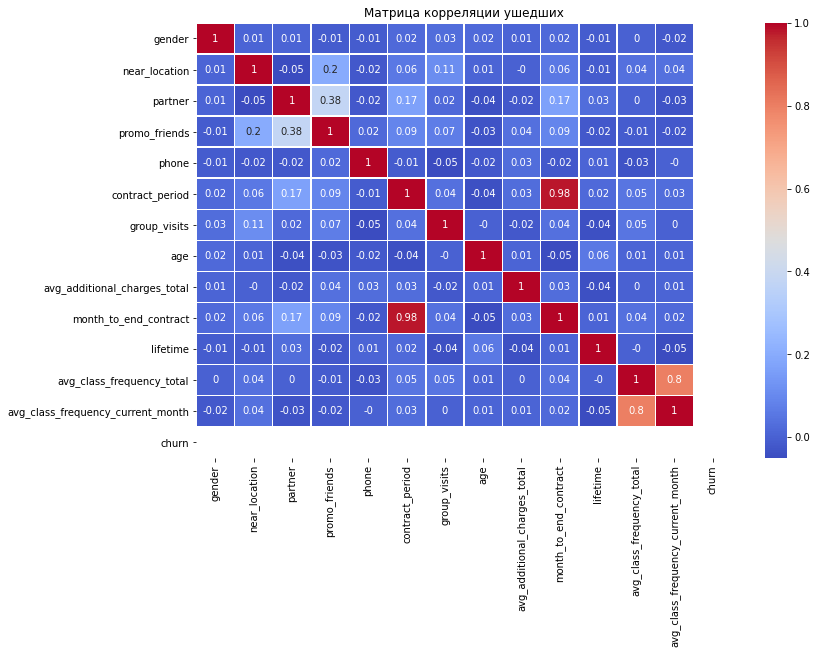

In [183]:
# Строим матрицу корреляций оставшихся
corr = round(data.query('churn == 1').corr(), 2)

plt.figure(figsize=(12, 8));
sns.heatmap(corr, linewidths=.5, annot = True, cmap='coolwarm').set_title('Матрица корреляции ушедших');

Здесь между партнёрской программой и промокодами практически осталась (**0,38**).

### Вывод по EDA

* Пропусков не было. Строковых данных совсем нет, а категорийные столбцы, вроде пола и наличие телефона переведены сразу в числовой вид.
* Перевели в целые числа колонку с месяцами
* Дубликатов строк не найдено.
<br /><br />

**Крактие выводы по статистике:**
* Большинство людей живут рядом с фитнес-центром - **0,84** среднее с небольшим разбросом
* Средний возраст клиентов **29** лет, причём с небольшим стандартным отклонением (**3,25**). В возрасте не видно выбросов в минимальном и максимальном значениях (между **18** и **41**).
* Медиана суммарной выручка от других услуг фитнес-центра: **136** у.е. с отклонением **96** у.е.
* Средняя частота посещений в неделю за все время с начала действия абонемента (медиана): **1,83** при отклонении **0,97**. В неделю за предыдущий месяц так же: **1,71**, при отклонении **1,05**
* Почти половина клиентов пришли по партнерской программе (**48%**)
* Отток клиентов составляет **26%**. Не знаком с общей статистикой фитнес-индустрии, но в наших интересах этот показатель сокращать.
* **30%** клиентов пришли по промокоду от друга
* **90%** клиентов указали телефон
* Средний срок жизни клиента **3,8 месяцев**. При этом большой разброс в **3 месяца**.
* Распределение по полу равномерное, с небольшим превалированием мужского пола (**+1%**)
<br /><br />

**Из заметного по средним значениям:**
* У не-партнёров больше отток, чем у партнёров
* Средняя длительность текущего действующего абонемента у ушедших ближе к месяцу (**0,99** против **4,71**)
* Ушедшие скорее больше не ходят на групповые занятия, чем ходят (**0,27** против **0,47**)
* Средний возраст ушедших ближе к **27** годам, а у оставшихся ближе к **30**
* Ушедшие тратили меньше на доп. услуги, чем оставшиеся (**115** у.е. против **158** у.е.)
* Среднее время с момента первого обращения в фитнес-центр у ушедших - всего **1 месяц**, а у оставшихся **4,7**.
* Ушедшие ходили в неделю реже, чем оставшиеся за всё время наблюдений: **1,47** против **2,02**.
    * А если смотреть только на предыдущий месяц, то разрыв ещё больше: почти **1 раз** против **2-х**.
    
Нарративом можно сказать, что средний ушедший - это клиент в возрасте 27 лет, который пришёл не по партнёрской программе и не по промокоду друга, со средним сроком жизни абонемента в 1 месяц. При этом абонемент закончится через месяц. Практически не ходил на групповые занятия, тратил меньше на доп. услуги и в 1,5-2 раза меньше посещений в неделю.
<br /><br />

**Выводы по гистограммам:**
* Распределение возраста нормальное. Видно, что среднее у групп отличается. Как писал ранее - у ушедших более молодой возраст.
* Доп. услуги у ушедших намного ниже. Это видно по модам.
* У оставшихся более распределенный график со сроком окончания абонемента: есть пики на 6 и 12 месяцев.
* Лайфтайм у оставшихся более насыщенный и с широким диапозоном
<br /><br />


**Выводы по графикам бинарных признаков**:
* В группе оттока мужчин больше
* На графике наглядно видно, что большинство клиентов, кто находится в районе фитнес-центра. Закономерно, что там обе группы больше.
* У партнёров меньше оттока
* Если клиент не был приглашён другом, то оттока больше
* Большинство клиентов не пользуются групповыми занятиями, но тех кто пользуется - ушедших достаточно мало.
<br /><br />

**Ящик с усами:**
* Из графиков ящика с усами видно, что верхняя граница срока жизни клиента - 12 месяцев и это может быть связано с годовым абонементом.
* Есть очень упорные клиенты, которые ходят по 5 и 6 раз в неделю.
* Интересно, что нет клиентов старше 41 года.
<br /><br />

**Выводы по общей матрице корреляции:**
* Есть мультиколлинеарные признаки (0,97) между длительностью текущего действующего абонемента и сроком до окончания текущего действующего абонемента. А также между частотами посещения клуба (0,95)
* Из интересного - обратная корреляция (-0,44) между оттоком и лайфтамом, частотой посещения в текущий месяц (-0,41), возрастом (-0,4).
* Есть нулевые корреляции между телефоном и промокодом полом и окончанием контракта.

## <span id='r3'>Модель прогнозирования оттока клиентов</span>

### Разбивка данных на обучающую и валидационную выборку

При анализе матрицы корреляции обнаружили, что есть две пары с **мультиколлинеарностью**. Модели регрессии чувствительны к таким сильным корреляциям, поэтому оставим только два значения.

Попробуем применить вычитание:
*(до этого сравнивал с обычным удалением одного из признаков в паре - показатель accuracy меньше на 0,2)* 🤯

In [184]:
# Делаем копию DF для ML
df = data.copy()

# Модифицируем мультиколлинеарные признаки в один
df['mc'] = df['month_to_end_contract'] - df['contract_period']
df['tm'] = df['avg_class_frequency_total'] - df['avg_class_frequency_current_month']

df = df.drop(['month_to_end_contract', 'contract_period', 
              'avg_class_frequency_total', 'avg_class_frequency_current_month'], axis=1)

df.head(3)

,gender,near_location,partner,promo_friends,phone,group_visits,age,avg_additional_charges_total,lifetime,churn,mc,tm
0,1,1,1,1,0,1,29,14.227470,3,0,-1,0.020398
1,0,1,0,0,1,1,31,113.202938,7,0,0,0.012693
2,0,1,1,0,1,0,28,129.448479,2,0,0,0.122596


Получили два признака, вместо четырёх.

In [185]:
# Разделим данные на признаки (матрица X) и целевую переменную (y)
X = df.drop('churn', axis = 1)
y = df['churn']

# Разделим модель на обучающую и валидационную выборку в соотношении 80/20, с установленной "случайностью"
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Обучение моделей

#### Логистическая регрессия

In [186]:
# Создаём функцию бенчмарка с выводом основных метрик задачи
def benchmark(y_test, predictions):
    # Выводим метрики после обучения
    print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
    print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
    print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))
    print('F1: {:.2f}'.format(f1_score(y_test, predictions)))

In [187]:
# Алгоритм для нашей модели
model = LogisticRegression(solver='liblinear')

# Обучаем модель
model.fit(X_train, y_train)

# Используем уже обученной моделью, чтобы сделать прогнозы
predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)[:,1]

# Выводим метрики после обучения
benchmark(y_test, predictions)

Accuracy: 0.92
Precision: 0.87
Recall: 0.78
F1: 0.82


Попробуем сделать логистическую регрессию со **стандартизацией данных**, т.к. семейство линейных чувствительны к этому:

In [188]:
# Стандартизируем
scaler = StandardScaler()
scaler.fit(X_train)

X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

model_st = LogisticRegression(solver='liblinear')
model_st.fit(X_train_st, y_train)

predictions_st = model_st.predict(X_test_st)
probabilities_st = model_st.predict_proba(X_test_st)[:,1]

# Выводим метрики
benchmark(y_test, predictions_st)

Accuracy: 0.92
Precision: 0.88
Recall: 0.80
F1: 0.84


Со стандартизацией показатели лучше на десятые доли, особенно F1.

Думаю, что метрика **recall** является важнее, т.к. лучше мы обнаружим отток и примем меры, даже если ошибемся, чем пропустим потенциальный убыток.

#### Случайный лес

Посмотрим на предсказания модели случайного леса.

In [189]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf_model.fit(X_train, y_train) 

rf_predictions = rf_model.predict(X_test) 
rf_probabilities = rf_model.predict_proba(X_test)[:,1]

# Выводим метрики
benchmark(y_test, rf_predictions)

Accuracy: 0.95
Precision: 0.94
Recall: 0.86
F1: 0.90


У случайного леса показатели намного лучше 👍

Посмотрим на важность признаков, которая выбрала модель:

In [190]:
# Функция выводит график с признаками
def feature_importance(columns, model):
    # Создаём DF с признаками модели
    importances = pd.DataFrame(data={'feature': columns, 'importance': model.feature_importances_})

    # Рисуем график
    plt.figure(figsize=(7, 5));
    sns.barplot(data=importances, x='importance', y='feature', 
                order=importances.sort_values(by='importance',ascending=False)['feature']). \
        set_title('Важность признаков модели');


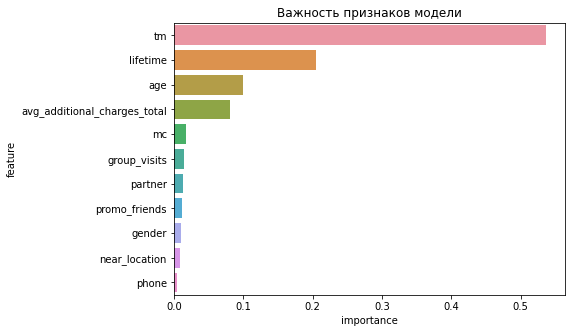

In [191]:
feature_importance(X.columns, rf_model)

Интересно, что модель выбрала главным признаком наше модифицированное поле по частоте посещения клуба в неделю. Видимо, это и правда важный показатель.<br />
На втором месте лайфтайм, на третьем возраст. на четвёртом - средний чек за доп. услуги.

В принципе всё то, что я писал в EDA.

Попробуем случайный лест со стандартизацией:

In [192]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model.fit(X_train_st, y_train)

rfs_predictions = rf_model.predict(X_test_st) 
rfs_probabilities = rf_model.predict_proba(X_test_st)[:,1]

# Выводим метрики
benchmark(y_test, rfs_predictions)

Accuracy: 0.95
Precision: 0.94
Recall: 0.86
F1: 0.90


Особой разницы не видно. Случайны лес по умолчанию работает неплохо без стандартизации.

#### CatBoost

Ради фана попробуем яндексовский catboost в работе.

In [193]:
# Создаем пулы датасетов. Пишут, что так будет эффективнее
train_dataset = cb.Pool(X_train, y_train) 
test_dataset = cb.Pool(X_test, y_test)

In [194]:
# Делаем поиск гиперпараметров, чтобы определить какая комбинация лучше всего
# ВНИМАНИЕ: для повторного поиска расскомментировать функции, но поиск идёт очень долго
model = cb.CatBoostClassifier(eval_metric = 'F1', verbose=100)

grid = {'iterations': [50, 100, 150, 200, 500, 1000, 2000],
        'learning_rate': [0.1, 0.03, 0.5],
        'depth': [1, 2, 3, 5, 7, 9],
        'bootstrap_type':['MVS', 'Bayesian', 'Bernoulli', 'Poisson', 'No'],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}
#grid_search_result = model.grid_search(grid, train_dataset, plot=True)

# Смотрим на лучшие параметры
#grid_search_result['params']

In [195]:
# Применяем найденные комбинации гиперпараметров
model = cb.CatBoostClassifier(eval_metric = 'F1',  # оценочная метрика 
                              verbose=4, # шаг отображения процесса
                              iterations=30,
                              depth=2, 
                              l2_leaf_reg=3, 
                              learning_rate=0.5,
                              bootstrap_type='Bernoulli')

# Обучаем модель
model.fit(
          train_dataset,
          eval_set=test_dataset, # защита от переобучения
          use_best_model=True # оставляем лучшую модель
         )
          
# Предсказываем
cat_predictions = model.predict(X_test) 

# Выводим метрики
benchmark(y_test, cat_predictions)

0:	learn: 0.7594575	test: 0.7428571	best: 0.7428571 (0)	total: 490us	remaining: 14.2ms
4:	learn: 0.8501292	test: 0.8651685	best: 0.8651685 (4)	total: 2.02ms	remaining: 10.1ms
8:	learn: 0.8785047	test: 0.9046322	best: 0.9046322 (8)	total: 3.49ms	remaining: 8.15ms
12:	learn: 0.8975904	test: 0.9230769	best: 0.9230769 (12)	total: 4.94ms	remaining: 6.46ms
16:	learn: 0.8986731	test: 0.9259259	best: 0.9287599 (13)	total: 6.37ms	remaining: 4.87ms
20:	learn: 0.9019844	test: 0.9365079	best: 0.9393140 (18)	total: 7.77ms	remaining: 3.33ms
24:	learn: 0.9086538	test: 0.9291339	best: 0.9393140 (18)	total: 9.21ms	remaining: 1.84ms
28:	learn: 0.9077844	test: 0.9267016	best: 0.9393140 (18)	total: 10.6ms	remaining: 365us
29:	learn: 0.9070186	test: 0.9291339	best: 0.9393140 (18)	total: 11ms	remaining: 0us

bestTest = 0.9393139842
bestIteration = 18

Shrink model to first 19 iterations.
Accuracy: 0.97
Precision: 0.98
Recall: 0.90
F1: 0.94


🏆 Улучшено на 0,04 и выжали максимум)

Посмотрим на важность признаков успешной модели на графике:

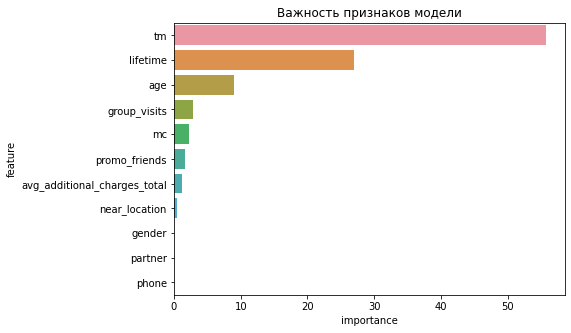

In [196]:
feature_importance(X.columns, model)

CatBoost в качестве признака не учитывал средний чек, а взял признак посещения групповых занятий. На первом месте всё так же наш модифицированный признак частоты похода в клуб.

### Выводы по обучению моделей

* При анализе матрицы корреляции обнаружили, что есть две пары с мультиколлинеарностью. Модели регрессии чувствительны к таким сильным корреляциям, поэтому оставили только два значения, где одно вычли из другого.
* При машинном обучении с помощью логистической регрессии со стандартизацией показатели лучше на десятые доли, особенно F1.
* Думаю, что метрика recall является важнее, т.к. лучше мы обнаружим отток и примем меры, даже если ошибемся, чем пропустим потенциальный убыток.
* У случайного леса показатели лучше на +0.6 по F1. При этом не было разницы после стандартизации данных.
* Интересно, что модель выбрала главным признаком наше модифицированное поле по частоте посещения клуба в неделю. Видимо, это и правда важный показатель.
На втором месте лайфтайм, на третьем возраст. на четвёртом - средний чек за доп. услуги.
* С помощью градиентного бустинга алгоритма CatBoost удалось и поиска гиперпараметров - удалось достичь максимальных показателей на валидационных данных: <br /><br />
<i>Accuracy: 0.97<br />
Precision: 0.98<br />
Recall: 0.90<br />
F1: 0.94</i>
<br /><br />
* CatBoost в качестве признака не учитывал средний чек, а взял признак посещения групповых занятий. На первом месте всё так же наш модифицированный признак частоты похода в клуб.

## <span id='r4'>Кластеризация</span>

### Рисуем дендрограмму

In [197]:
# Стандартизация данных
data_k = data.copy()
data_k = data_k.drop('churn', axis=1)


scaler = StandardScaler()
X_sc = scaler.fit_transform(data_k)

# Сохраненим таблицу «связок» между объектами.
linked = linkage(X_sc, method = 'ward') 

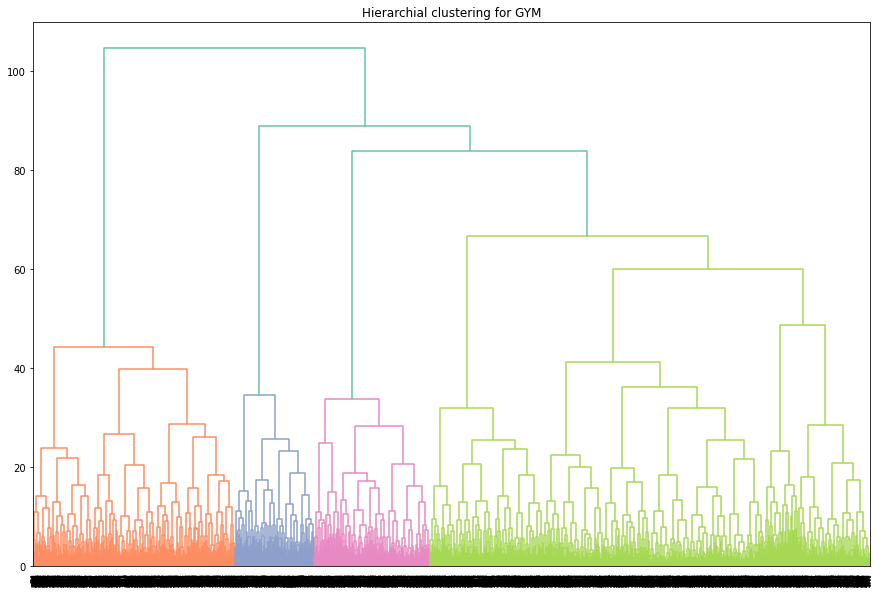

In [198]:
# Отрисуем дендрограмму
# ВНИМАНИЕ: при расскомментировании обработка функции занимает много времени
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show() 

Судя по дендрограмме - можно выделить 4-5 кластеров.

### Разбиваем на кластеры через K-Means

Теперь обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов:

In [199]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 2)
labels = km.fit_predict(X_sc)

# сохраняем метки кластера в поле нашего датасета
data_k['cluster'] = labels

In [200]:
# Посмотрим на распределение по кластерам
data_k['cluster'].value_counts()

3    1262
0    1010
4     838
2     505
1     385
Name: cluster, dtype: int64

In [206]:
# выводим статистику по средним значениям наших признаков по кластеру
cluster_features = data_k.groupby('cluster').mean().reset_index()
numeric_columns = cluster_features.drop(columns=['cluster']).columns
cluster_features.style.format({i: '{:.2f}' for i in numeric_columns}) \
    .highlight_max(color='yellowgreen', subset=numeric_columns) \
    .highlight_min(color='coral', subset=numeric_columns)

,cluster,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
0,0,0.50,0.96,0.78,0.57,1.00,10.89,0.54,29.98,160.76,9.95,4.74,1.98,1.97
1,1,0.52,0.86,0.47,0.31,0.00,4.79,0.43,29.30,143.96,4.48,3.92,1.85,1.72
2,2,0.50,0.00,0.46,0.08,1.00,2.35,0.22,28.48,135.46,2.20,2.81,1.66,1.48
3,3,0.49,1.00,0.35,0.24,1.00,1.95,0.34,28.17,131.62,1.86,2.44,1.25,1.01
4,4,0.56,0.98,0.36,0.23,1.00,2.67,0.47,30.13,161.66,2.46,4.90,2.85,2.85


Что можно сразу заметить:
* Гендерное распределение более-менее равномерно, кроме небольшого отклонения в кластере 4
* Кластере 2 (505 клиентов) выделяется, что клиенты находятся не в районе фитнес-центра. Также тем, что пришли не по промокоду друга
* Кластер 1 (385 клиентов) не указали контактный телефон
* Кластер 3, самая многочисленная (1262), живёт в районе фитнес-центра, но низкий показатель частоты похода в клуб.
* В кластере 4 (838) самый большой лайфтайм (4,9), самый высокий показатель средней выручки за доп. услуги (161,66) и частота похода в клуб (2,85).
* В кластере 0 (1010) также большой лайфтайм (4,7), выручка услуг (160,76). Кластер более партнёрский (0,78). Самый большой срок до окончания текущего действующего абонемента (9,95), а также длительность текущего абонемента (10,9 месяцев). Выше всех показатель групповых занятий (0,54). С 57% вероятностью они пришли по промо-коду друга. Можно сказать, что это одна из самых лояльных групп. 

### Графики распределения признаков для кластеров

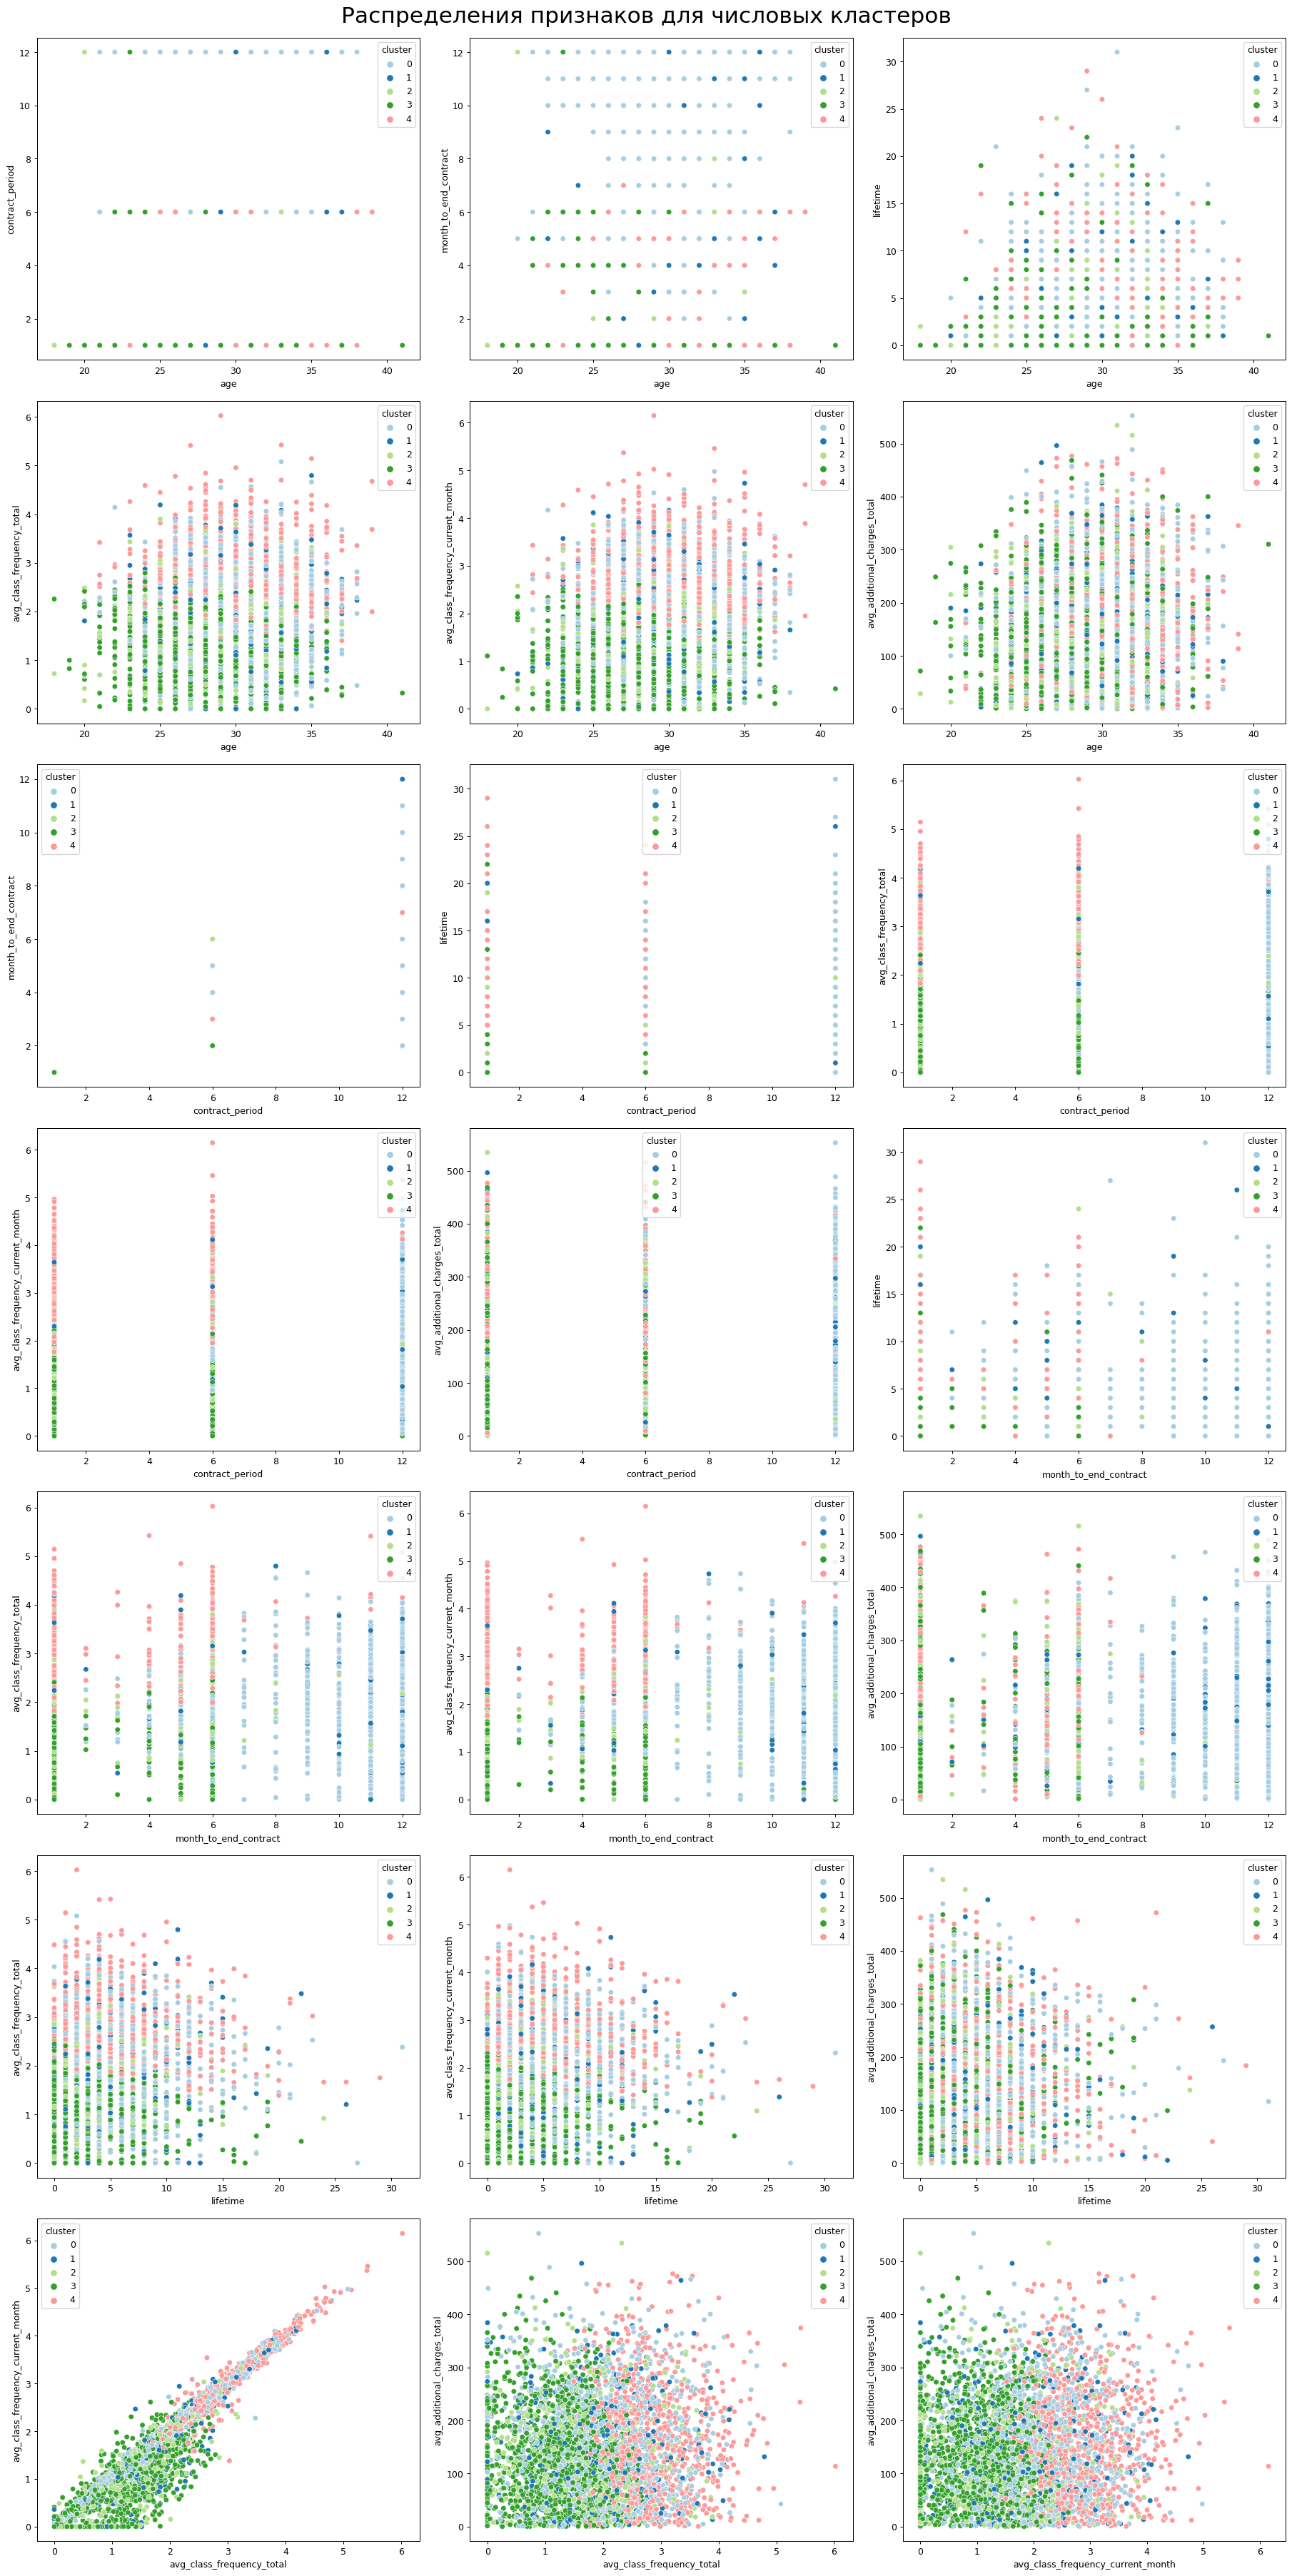

In [207]:
# Отрисуем графики с непрерывными признаками
f, axes = plt.subplots(nrows=7, ncols=3, figsize=(20, 40), dpi=90, constrained_layout=True)

cols = ['age', 'contract_period', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', 
        'avg_class_frequency_current_month', 'avg_additional_charges_total']

# отрисуем графики для попарных сочетаний признаков с разметкой по кластерам
col_pairs = list(combinations(cols, 2))
i = 0
j = 0

for pair in col_pairs:
    # Счётчики для расположения графиков на листе
    if i == 3:
        i = 0
        j += 1
    
    sns.scatterplot(data=data_k, x=pair[0], y=pair[1], 
                    hue='cluster', palette='Paired', ax=axes[j, i])
    i += 1
    
f.suptitle('Распределения признаков для числовых кластеров', fontsize=25);

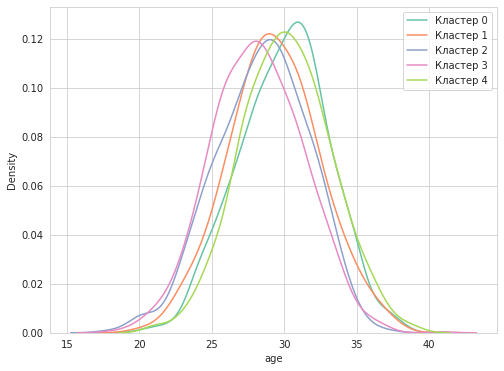

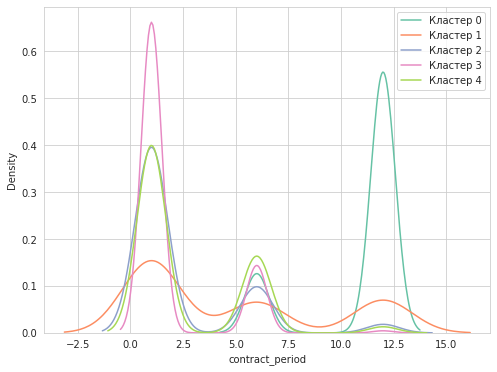

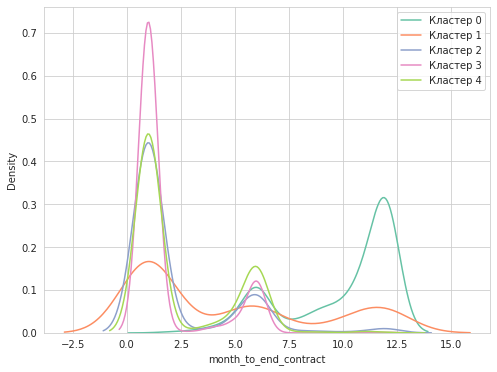

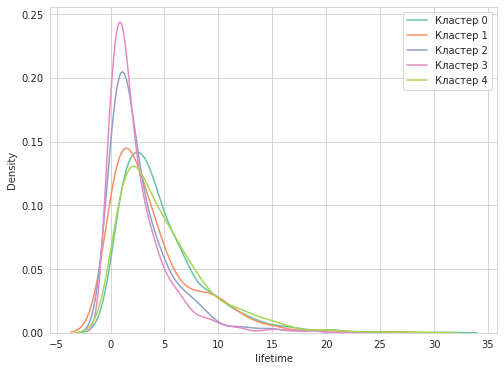

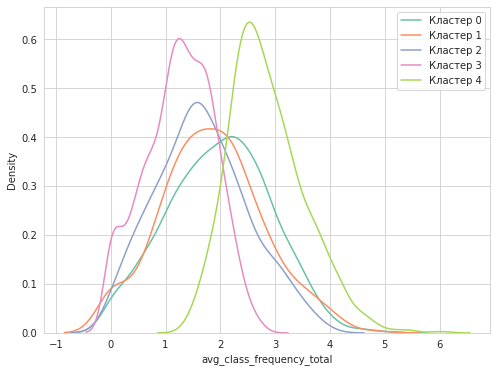

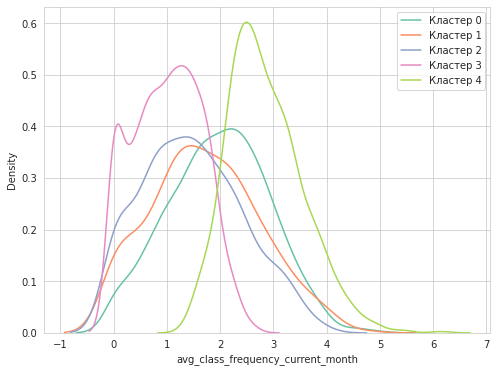

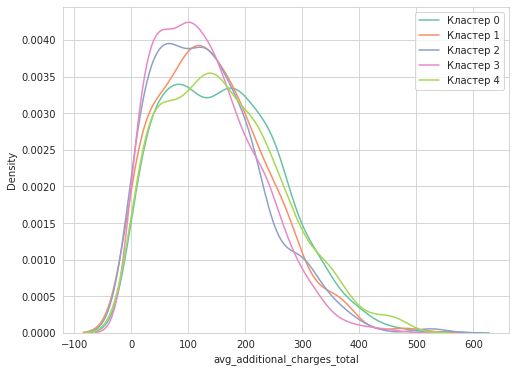

In [270]:
# Отрисуем графики с непрерывными признаками

for column in ['age', 'contract_period', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', 
               'avg_class_frequency_current_month', 'avg_additional_charges_total']:
   
    plt.figure(figsize=(8, 6))  
    
    # Прогоняем все кластеры в цикле
    for i in range(len(data_k.groupby('cluster'))):
        sns.kdeplot(data_k.query('cluster == ' + str(i))[column], label = 'Кластер ' + str(i))
    
    plt.legend()
    plt.show()
    sns.set_style('whitegrid')


В частоте посещения в неделю (общий период) видно как кластер 4 вырвался вперёд, а в 3 - наоборот, малая частота.

В сроке абонемента нагляднейше видно, чем отличается группа оттока 3, от лояльных 0. По модам - 1 и 12.

В лайфтайме тоже видна разница между кластерами 0 и 3.

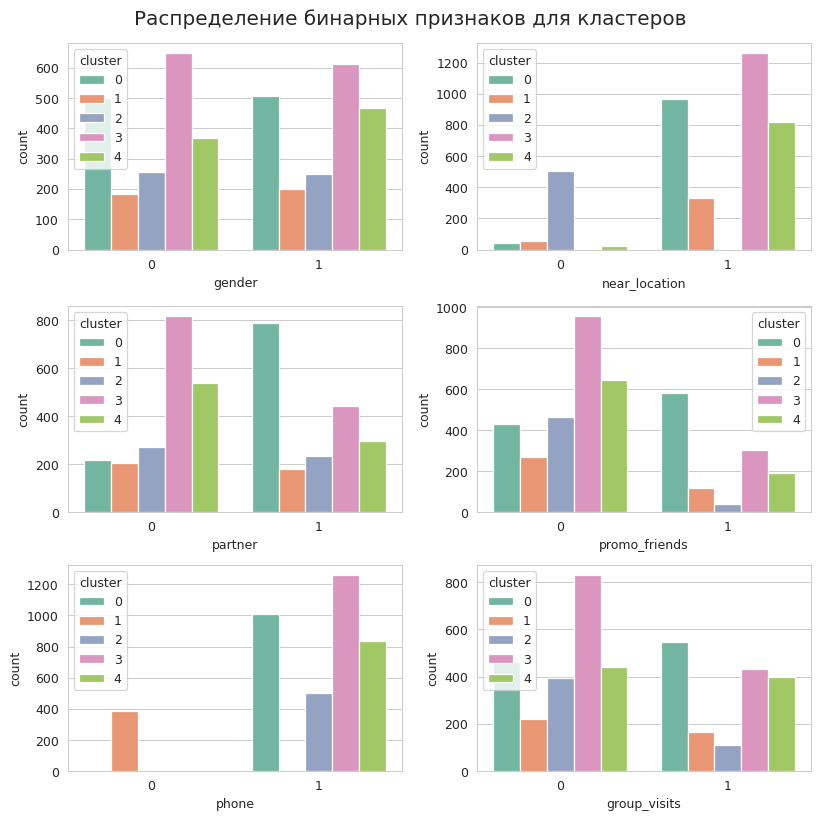

In [271]:
# Располагаем графики на одном листе с колонками и рядами
f, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 9), dpi=90, constrained_layout=True)

# В цикле генерим графики по каждому полю
i = 0
j = 0

for col in ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']:
    if i == 2:
        i = 0
        j += 1
    
    # Строим графики
    sns.set_palette('Set2')
    sns.countplot(data=data_k, x=data[col], hue='cluster', ax=axes[j, i])
    i += 1
        
    f.suptitle('Распределение бинарных признаков для кластеров', fontsize=16);

На этих графиках наглядно видно, что, например, кластер 0 более "партнёрский", кластер 1 без телефонов, кластер 3 и 4 живут в одном районе.

### Доля оттока

In [40]:
# Добавляем удалённую колонку оттока
data_k['churn'] = data['churn']
# Считаем среднее
round(data_k.groupby('cluster').agg({'churn':'mean'}).sort_values('churn'), 2)

,churn
cluster,
0,0.03
4,0.07
1,0.27
2,0.44
3,0.51


Предсказуемо, лояльный кластер 0 (1010 клиентов) с наименьшей долей оттока. А также кластер 4 (838) с самым большой лайфтаймом, показателем средней выручки за доп. услуги и частота похода в клуб.

Кластеры 2 (505 клиентов) и 3 (1262) с самым низким лайфтаймом, средним чеком выручки, посещением групповых занятий. У кластера 3 самая низкая частота посещаемость клуба, маленький срок действующего абонемента. А кластер 2 живёт не в районе фитнес-клуба и пришли не по промокоду друга. Всё это как следствие влияет на высокую, по сравнению с другими кластерами, долю оттока.

Кластер 1 - крепкие середнячки (385 клиентов) с 27% процентами оттока. Выбивается только тем, что не указали контактный телефон.

### Выводы по кластеризации

* Была успешно построена дендрограмма. Судя по ней - можно выделить **4-5 кластеров**.
* Для кластеризации применили алгоритм K-Means с установленным количеством кластеров равному **5**. Вот что удалось обнаружить глядя на **усредненные данные кластеров**:
    * Гендерное распределение более-менее равномерно, кроме небольшого отклонения в кластере 4
    * Кластере 2 (505 клиентов) выделяется, что клиенты находятся не в районе фитнес-центра. Также тем, что пришли не по промокоду друга
    * Кластер 1 (385 клиентов) не указали контактный телефон
    * Кластер 3, самая многочисленная (1262), живёт в районе фитнес-центра, но низкий показатель частоты похода в клуб.
    * В кластере 4 (838) самый большой лайфтайм (4,9), самый высокий показатель средней выручки за доп. услуги (161,66) и частота похода в клуб (2,85).
    * В кластере 0 (1010) также большой лайфтайм (4,7), выручка услуг (160,76). Кластер более партнёрский (0,78). Самый большой срок до окончания текущего действующего абонемента (9,95), а также длительность текущего абонемента (10,9 месяцев). Выше всех показатель групповых занятий (0,54). С 57% вероятностью они пришли по промо-коду друга. Можно сказать, что это одна из самых лояльных групп. 
    
* Судя по совместным графикам: В частоте посещения в неделю (общий период) видно как кластер 4 вырвался вперёд, а в 3 - наоборот, малая частота.
* В сроке абонемента нагляднейше видно, чем отличается группа оттока 3, от лояльных 0. По модам - 1 и 12.
* В лайфтайме тоже видна разница между кластерами 0 и 3.
* На графиках бинарных признаков наглядно видно наглядно видно, что, например, кластер 0 более "партнёрский", кластер 1 без телефонов, кластер 3 и 4 живут в одном районе.
<br />

По **долям оттока**:
* Предсказуемо, лояльный кластер 0 (1010 клиентов) с наименьшей долей оттока. А также кластер 4 (838) с самым большой лайфтаймом, показателем средней выручки за доп. услуги и частота похода в клуб.

* Кластеры 2 (505 клиентов) и 3 (1262) с самым низким лайфтаймом, средним чеком выручки, посещением групповых занятий. У кластера 3 самая низкая частота посещаемость клуба, маленький срок действующего абонемента. А кластер 2 живёт не в районе фитнес-клуба и пришли не по промокоду друга. Всё это как следствие влияет на высокую, по сравнению с другими кластерами, долю оттока.

* Кластер 1 - крепкие середнячки (385 клиентов) с 27% процентами оттока. Выбивается только тем, что не указали контактный телефон.


## <span id='r5'>Общие выводы</span>

**Проделанная работа:**
1. Был дан датасет с данными фитнес-центра и их клиентов с показателями оттока. Задача была в том, чтобы сделать анализ данных и подготовить план действий по удержанию клиентов. Научиться прогнозировать вероятность оттока для каждого клиента. Сформировать типичные портреты клиентов с помощью кластеризации. Написать рекомендации для бизнеса.
<br />

2. В этапе EDA данные были проверены на пропуски и дубликаты, категории на уникальность. С помощью описательной статистики удалось выявить нарратив среднего ушедшего клиента:<br />
<i>Нарративом можно сказать, что средний ушедший - это клиент в возрасте 27 лет, который пришёл не по партнёрской программе и не по промокоду друга, со средним сроком жизни абонемента в 1 месяц. При этом абонемент закончится через месяц. Практически не ходил на групповые занятия, тратил меньше на доп. услуги и в 1,5-2 раза меньше посещений в неделю.</i>
<br />

3. При анализе матрицы корреляции обнаружили, что есть две пары с мультиколлинеарностью. Т.к. были планы построить модель логистической регрессии - близкие признаки были модифицированы.<br />
Разработаны модели с помощью трёх алгоритмов: логистической регрессии, случайного леса и catboost. Благодаря поиску гиперпараметров в catboost - удалось добиться высоких метрик: <i>Precision: 0.98, Recall: 0.90, F1: 0.94</i>.
<br />

4. Для кластеризации был применён алгоритм K-means с количеством групп 5. После усреднения показателей и графиков - удалось выявить группы лояльных, оттока и середнячков. На графиках наглядно видно, что есть значимые отличия между противоположными группами в сроке абонемента, лайфтайме и частоте похода в клуб.
<br />

**Рекомендации для бизнеса:**

1. Была успешна протестирована на валидационных данных предсказательная модель. Благодаря алгоритму `CatBoost` удалось добиться высоких показателей точности. Модель можно запускать в деплой и внедрять в бизнес-процессы. Раннее оповещение о возможности ухода клиента будет сигналом для маркетингового отдела. Вполне возможно создать автоматизированные воронки для этого кластера и уменьшать показатель оттока.
<br />

2. Самые лояльные клиенты с высоким `Lifetime`, но сложно определить причинно-следственные связи. Можно сказать, что наиболее лояльные клиенты находятся в одном районе с фитнес-центром, а также приходят по промокоду от друга. Маркетинговому отделу стоит обратить внимание на геотаргетинг при рекламе, а также дополнительно уведомлять действующих клиентов о возможности приглашать друзей и получать за это плюшки.
<br />

3. У ушедших клиентов была малая частота посещений клуба. Можно ориентироваться на этот показатель и "приучать" или помогать клиентам с помощью тренеров, чтобы увеличить регулярность. Человеку, который заранее договорился о расписании с живым тренером - гораздо сложнее прогуливать. А там уже втянется.
<br />

4. Немаловажный фактор - это возраст. Средний возраст у ушедших и оставшихся: 27 против 30 лет. Предсказательная модель также ставит этот признак на 3 место. При интернет-рекламе можно это учитывать и таргетировать сразу на нужное ЦА: 30-35 лет.
<br />

5. Ещё у предсказательной модели на четвёртом месте стоит признак посещения групповых занятий. Также можно при онбординге помочь новичкам выбрать интересные для него программы.
<br />

6. При большем срок абонемента - выше показатели. Но как я писал выше, нельзя пока определить причинно-следственные связи. Как гипотезу - можно попробовать продавать годовой абонемент с большой скидкой. Бизнес-модель фитнес-клубов устроена по принципу: купи на год и можешь не ходить или ходит малое количество. Почему здесь есть вариант месяцы и половины года - для меня вопрос.
<br />

7. Партнёрская программа имеет смысл. В лояльном кластере 78% клиентов (от более чем тысячи живых клиентов), имела признак партнёрской программы, при среднем показателе 48%. Поэтому в стратегию можно заложить развитие этого направления.